<div align='left' style="width:400px;height:120px;overflow:hidden;">
<img align='left' style='display: block;height: 92%' src='imgs/riotext.png' alt='RIO logo' title='RIO logo'/>
</div>

## Machine Learning

# 5. Programming Neural Networks with TensorFlow

### by [Nayat Sánchez Pi](http://www.nayatsanchezpi.com) and [Luis Martí](http://lmarti.com)
$\renewcommand{\vec}[1]{\boldsymbol{#1}}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random, os, time

# nice progress bars
from tqdm import tnrange
%matplotlib inline

In [2]:
# code for rendering a TF graph inline in a Jupyter notebook
from IPython.display import clear_output, Image, display, HTML


def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(
        data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In this practical class we will review the use of TensorFlow for programming neural networks.
* We will address the MNIST image classification problem.
* Program a logistic regression classifier.
* Program a multi-layer Perceptron.
* Experiment with different activation functions.
* Use TensorBoard for logging results.

## Loading MNIST data

TensorFlow includes a MNIST dataset loader for the sake of learning and experimentation (our case!). If necessary it will download the data.

In [3]:
import tensorflow as tf

In [4]:
## Uncomment to use GPU
# tf.device('/device:GPU:0')

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets('data', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts: 
* `mnist.train`: 55000 data points of training data
* `mnist.test`: 10000 points of test data, and 
* `mnist.validation`: 5000 points of validation data.

<div class="container-fluid">
  <div class="row">
      <div class="col-md-2" align='center'>
      </div>
      <div class="col-md-8">
              <img src='https://www.tensorflow.org/versions/r1.1/images/mnist-train-xs.png'/>
      </div>
      <div class="col-md-2" align='center'>
      </div>
  </div>
</div>

Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

<div class="container-fluid">
  <div class="row">
      <div class="col-md-2" align='center'>
      </div>
      <div class="col-md-8">
              <img src='https://www.tensorflow.org/versions/r1.1/images/MNIST-Matrix.png'/>
      </div>
      <div class="col-md-2" align='center'>
      </div>
  </div>
</div>

* We can flatten this array into a vector of 28x28 = 784 numbers. 
* Flattening the data throws away information about the 2D structure of the image. 
* Computer vision methods like Convolutional Neural Networks exploit this structure. 
* The simple methods we will be using here, won't,

In [7]:
mnist.train.images.shape

(55000, 784)

For the purposes of this tutorial, we're going to want our labels as "one-hot vectors".
* A one-hot vector is a vector which is $0$ in most dimensions, and $1$ in a single dimension. 
* In this case, the $i$th digit will be represented as a vector which is $1$ in the $i$th dimension. 
* For example, $3$ would be $[0,0,1,0,0,0,0,0,0,0,0]$. 
* Consequently, `mnist.train.labels` is a [55000, 10] array of floats.

In [8]:
mnist.train.labels.shape

(55000, 10)

In [9]:
def display_digit(num, mnist):
    label = mnist.train.labels[num].argmax(axis=0)
    image = mnist.train.images[num].reshape([28, 28])
    plt.title('Id: {};\n$l$: {} - {}'.format(
        num, label, mnist.train.labels[num]))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))

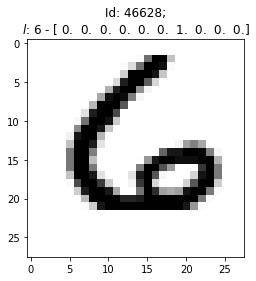

In [10]:
display_digit(random.randint(0, len(mnist.train.images)), mnist)

In [11]:
def display_mult_flat(start, stop, mnist):
    images = mnist.train.images[start].reshape([1, 784])
    for i in range(start + 1, stop):
        images = np.concatenate((images,
                                 mnist.train.images[i].reshape([1, 784])))
    plt.figure(figsize=(11, 6))
    plt.imshow(images.T, cmap=plt.get_cmap('gray_r'), aspect='auto')
    plt.xlabel('Dataset index')
    plt.ylabel('Input vector $\mathbf{x}$')

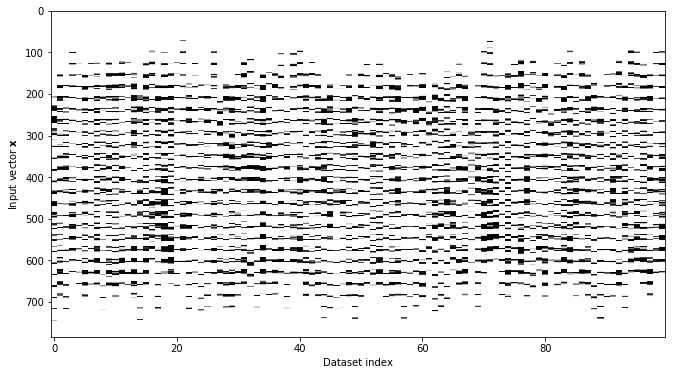

In [12]:
display_mult_flat(0, 100, mnist)

## Implementing Logistic regression

You can picture our softmax regression as looking something like the following (but with a lot more $x$s):

* For each output, we compute a weighted sum of the $x_i$s add a bias, and then apply softmax.

`X` isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation. 
* We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
* We represent this as a 2-D tensor of floating-point numbers, with a shape `[None, 784]`. 
* Here `None` means that a dimension can be of any length.

In [13]:
X = tf.placeholder(tf.float32, [None, 784], name='inputs')

We also need the weights and biases for our model. 
* We could imagine treating these like additional inputs, but TensorFlow has an even better way to handle it: `tf.Variable`. 
* A `tf.Variable` is a modifiable tensor that lives in TensorFlow's graph of interacting operations. 
* It can be used and even modified by the computation. 
* For machine learning applications, the model parameters are `tf.Variable`s.

In [14]:
W = tf.Variable(tf.zeros([784, 10]), name='weights')
b = tf.Variable(tf.zeros([10]), name='biases')

We can now implement our model. It only takes one line to define it!

In [15]:
y_hat = tf.nn.softmax(tf.matmul(X, W) + b, name='y_hat')

Cross-entropy arises from thinking about information compressing codes in information theory but it winds up being an important idea in lots of areas, from gambling to machine learning. It's defined as:

$$ J_{\Psi}(\vec{y}, \hat{\vec{y}}) = \frac{1}{\left|\Psi\right|}\sum_{\forall \langle\vec{x}^{(i)},\vec{y}^{(i)}\rangle\in\Psi}-\sum_{j}{y^{(i)}_{j}\log\left(\hat{y}_j\left(\vec{x}^{(i)}\right)\right)}. $$

To implement cross-entropy we need to first add a new placeholder to supply the correct answers:

In [16]:
y = tf.placeholder(tf.float32, [None, 10], 'y_expected')

In [17]:
loss = tf.reduce_mean(
    -tf.reduce_sum(
        y * tf.log(tf.clip_by_value(y_hat, 1e-10, 1.0)), name='cross_entropy', reduction_indices=1),
    name='logreg_loss')

1. `tf.log()` computes the logarithm of each element of `y_hat`,
2. we multiply each element of `y` with the corresponding element of `tf.log(y_hat)`.
3. the `tf.clip_by_value(y_hat, 1e-10, 1.0)` statement is meant for avoiding a $\log(0)$ which is a NaN.
4. `tf.reduce_sum()` adds the elements in the second dimension due to the `reduction_indices=[1]` parameter.
5. Finally, tf.reduce_mean computes the mean over all the examples in the batch.

Let's examine the graph of the operations we have just coded. *This might not render properly in Safari.*

In [18]:
show_graph(tf.get_default_graph())

## Next step: Training

Next, we ask TensorFlow to minimize cross_entropy using the gradient descent algorithm.

*Further exploration tips:* Experiment using other optimization algorithms present in the `tf.train` module.

In [19]:
def train_model_sgd(loss_function,
                    learning_rate,
                    batch_size,
                    max_epochs,
                    print_freq=10):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss_function)

    num_batches = mnist.train.num_examples // batch_size

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(tf.global_variables_initializer())

        for epoch in tnrange(max_epochs, desc='Epoch:'):
            accum = 0
            for batch in range(num_batches):
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                _, c = sess.run(
                    [optimizer, loss_function],
                    feed_dict={
                        X: batch_xs,
                        y: batch_ys
                    })
                accum += c

            if epoch % print_freq == 0:
                print('Epoch {}, training loss: {}'.format(
                    epoch + 1, accum / num_batches))

        test_loss = sess.run(
            loss_function,
            feed_dict={
                X: mnist.test.images,
                y: mnist.test.labels
            })

        print('Test set loss: {}'.format(test_loss))

We are now ready to train our classifier:

In [20]:
learning_rate = 0.5
batch_size = 100
max_epochs = 20

In [21]:
train_model_sgd(loss, learning_rate, batch_size, max_epochs, print_freq=1)

Epoch 1, training loss: 0.3998796918920495
Epoch 2, training loss: 0.3097397803447463
Epoch 3, training loss: 0.29569432148879227
Epoch 4, training loss: 0.2865829070454294
Epoch 5, training loss: 0.28123562781648204
Epoch 6, training loss: 0.2777144649489359
Epoch 7, training loss: 0.2749492767588659
Epoch 8, training loss: 0.2716533203558488
Epoch 9, training loss: 0.2698827165229754
Epoch 10, training loss: 0.2682908943160014
Epoch 11, training loss: 0.26629530811851676
Epoch 12, training loss: 0.26436222417788074
Epoch 13, training loss: 0.26310901752927085
Epoch 14, training loss: 0.26208716477860106
Epoch 15, training loss: 0.2600771647014401
Epoch 16, training loss: 0.26050942621447826
Epoch 17, training loss: 0.25833797973665323
Epoch 18, training loss: 0.25825897151773625
Epoch 19, training loss: 0.25760014722293073
Epoch 20, training loss: 0.2564008441431956

Test set loss: 0.27828800678253174


## Reporting updates via TensorBoard

Training a massive (deep) neural network can be:
* complex, 
* time consuming, and 
* with a high degree of uncertainty. 

TensorBoard is a suite of visualization tools to make it easier to monitor, understand, debug, and optimize the learning process.

First, we need to define what quantities we want to track. In our case, accuracy and the loss.

In [22]:
accuracy = tf.reduce_mean(
    tf.to_float(tf.equal(tf.arg_max(y_hat, 1), tf.arg_max(y, 1))))
a = tf.summary.scalar("accuracy", accuracy)
l = tf.summary.scalar("loss", loss)
summaries = tf.summary.merge((a, l))

We now need improve out training function for reporting the results to TensorBoard.

In [23]:
def train_model_sgd_tensorboard(loss_function,
                                learning_rate,
                                batch_size,
                                max_epochs,
                                print_freq=10,
                                summaries=None,
                                tag='unk',
                                logs_path='logs'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss_function)

    num_batches = mnist.train.num_examples // batch_size

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        suffix = time.strftime('%Y%m%d-%H%M%S') + '-' + tag

        writer_training = tf.summary.FileWriter(
            os.path.join(logs_path, 'training', suffix), graph=sess.graph)
        writer_validation = tf.summary.FileWriter(
            os.path.join(logs_path, 'validation', suffix), graph=sess.graph)

        for epoch in tnrange(max_epochs, desc='Epoch:'):
            accum = 0
            for batch in range(num_batches):
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                _, c, summs = sess.run(
                    [optimizer, loss_function, summaries],
                    feed_dict={
                        X: batch_xs,
                        y: batch_ys
                    })
                accum += c
                writer_training.add_summary(summs, epoch * num_batches + batch)

            val_summs = sess.run(
                summaries,
                feed_dict={
                    X: mnist.validation.images,
                    y: mnist.validation.labels
                })

            writer_validation.add_summary(val_summs, (epoch + 1) * num_batches)

            if epoch % print_freq == 0:
                print('Epoch {}, training loss: {}.'.format(
                    epoch, accum / num_batches))

        writer_training.close()
        writer_validation.close()

        test_loss = sess.run(
            loss_function,
            feed_dict={
                X: mnist.test.images,
                y: mnist.test.labels
            })

        print('Test set loss: {}'.format(test_loss))

Before proceeding we need to run tensorboard from the command line passing as argument the folder we are using for logging results:

```bash
$ tensorboard --logdir=logs
```

Let's repeat the training.

In [24]:
%%time
train_model_sgd_tensorboard(
    loss,
    learning_rate,
    batch_size,
    max_epochs,
    summaries=summaries,
    print_freq=1,
    tag='log-reg')

Epoch 0, training loss: 0.40061040219935506.
Epoch 1, training loss: 0.31053119469772683.
Epoch 2, training loss: 0.293814892958511.
Epoch 3, training loss: 0.28724375476891345.
Epoch 4, training loss: 0.2810712426765399.
Epoch 5, training loss: 0.27751626377755945.
Epoch 6, training loss: 0.2738130528818477.
Epoch 7, training loss: 0.2725402255627242.
Epoch 8, training loss: 0.26927772190083155.
Epoch 9, training loss: 0.2672062130949714.
Epoch 10, training loss: 0.2655645806003701.
Epoch 11, training loss: 0.2651162028312683.
Epoch 12, training loss: 0.26326855622909284.
Epoch 13, training loss: 0.2622323137250814.
Epoch 14, training loss: 0.2613115574690429.
Epoch 15, training loss: 0.26006238434802403.
Epoch 16, training loss: 0.2592030907760967.
Epoch 17, training loss: 0.25787571782415564.
Epoch 18, training loss: 0.2567252761667425.
Epoch 19, training loss: 0.25649006537415764.

Test set loss: 0.27907589077949524
CPU times: user 25.4 s, sys: 8.46 s, total: 33.9 s
Wall time: 18.2

## Coding a MLP

In [25]:
num_hidden_neurons = 20

In [26]:
W_hidden = tf.Variable(tf.random_normal([784, num_hidden_neurons], stddev=0.001), name='hidden_weights')
b_hidden = tf.Variable(tf.random_normal([num_hidden_neurons], stddev=0.001), name='hidden_biases')

In [27]:
y_hidden = tf.nn.tanh(tf.matmul(X, W_hidden) + b_hidden, name='y_hidden')

In [28]:
W_output = tf.Variable(tf.random_normal([num_hidden_neurons, 10], stddev=0.001), name='output_weights')
b_output = tf.Variable(tf.random_normal([10], stddev=0.001), name='output_biases')

In [29]:
y_hat = tf.nn.softmax(tf.matmul(y_hidden, W_output) + b_output, name='y_hat_nn')

In [30]:
# loss = tf.reduce_mean(
#     -tf.reduce_sum(
#         y * tf.log(y_hat+0.000000000000001), name='cross_entropy_nn', reduction_indices=1),
#     name='mlp_loss')

In [31]:
#accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.arg_max(y_hat, 1), tf.arg_max(y, 1))))
#a = tf.summary.scalar("accuracy", accuracy)
#b = tf.summary.scalar("loss", loss)
#summaries = tf.summary.merge((a, b))

In [32]:
%%time
train_model_sgd_tensorboard(loss, learning_rate, batch_size, 200, summaries=summaries, tag='mlp')

Epoch 0, training loss: 0.3998267641392621.
Epoch 10, training loss: 0.26544474588199096.
Epoch 20, training loss: 0.25651880896226925.
Epoch 30, training loss: 0.25044760970906776.
Epoch 40, training loss: 0.24684746763922952.
Epoch 50, training loss: 0.24416154503822327.
Epoch 60, training loss: 0.24165729835629463.
Epoch 70, training loss: 0.240639235438271.
Epoch 80, training loss: 0.23907485394315287.
Epoch 90, training loss: 0.23779703974723815.
Epoch 100, training loss: 0.2373475071516904.
Epoch 110, training loss: 0.23576932229778982.
Epoch 120, training loss: 0.2352442883767865.
Epoch 130, training loss: 0.23428280677307736.
Epoch 140, training loss: 0.23334349036216737.
Epoch 150, training loss: 0.233470766490156.
Epoch 160, training loss: 0.23206957746635784.
Epoch 170, training loss: 0.2326464376530864.
Epoch 180, training loss: 0.23099768287756225.
Epoch 190, training loss: 0.23016047423536126.

Test set loss: 0.28763970732688904
CPU times: user 4min 21s, sys: 1min 19s, to

We can clearly observe overfitting taking place!

<div class="container-fluid">
  <div class="row">
      <div class="col-md-2" align='center'>
      </div>
      <div class="col-md-8">
              <img src='imgs/05/overfitting.png'/>
      </div>
      <div class="col-md-2" align='center'>
      </div>
  </div>
</div>

## Impact of other activation functions

Let's try the ReLU activation function that we saw in class. Remember that ReLU is defined as:

$$
\hat{y} = \max(0, net).
$$

In [33]:
num_hidden_neurons = 40
W_hidden = tf.Variable(tf.random_normal([784, num_hidden_neurons], stddev=0.001), name='hidden_weights')
b_hidden = tf.Variable(tf.random_normal([num_hidden_neurons], stddev=0.001), name='hidden_biases')
y_hidden = tf.nn.relu(tf.matmul(X, W_hidden) + b_hidden, name='y_hidden')
W_output = tf.Variable(tf.random_normal([num_hidden_neurons, 10], stddev=0.001), name='output_weights')
b_output = tf.Variable(tf.random_normal([10], stddev=0.001), name='output_biases')
y_hat = tf.nn.softmax(tf.matmul(y_hidden, W_output) + b_output, name='y_hat_nn')
# loss = tf.reduce_mean(
#     -tf.reduce_sum(
#         y * tf.log(y_hat+0.0000000000001), name='cross_entropy_nn', reduction_indices=1),
#     name='mlp_loss')
#accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.arg_max(y_hat, 1), tf.arg_max(y, 1))))
#a = tf.summary.scalar("accuracy", accuracy)
#b = tf.summary.scalar("loss", loss)
#summaries = tf.summary.merge((a, b))

In [34]:
%%time
train_model_sgd_tensorboard(loss, learning_rate, batch_size, 200, summaries=summaries, tag='mlp-relu-2')

Epoch 0, training loss: 0.39895227746530015.
Epoch 10, training loss: 0.2658638096126643.
Epoch 20, training loss: 0.2553171923485669.
Epoch 30, training loss: 0.2506874832240018.
Epoch 40, training loss: 0.2469164595820687.
Epoch 50, training loss: 0.2446584794602611.
Epoch 60, training loss: 0.2422431962733919.
Epoch 70, training loss: 0.23997521017085421.
Epoch 80, training loss: 0.23875595593994314.
Epoch 90, training loss: 0.23835829508575526.
Epoch 100, training loss: 0.23599571956152265.
Epoch 110, training loss: 0.2357209042527459.
Epoch 120, training loss: 0.23442960083484649.
Epoch 130, training loss: 0.2341477763585069.
Epoch 140, training loss: 0.23343661056323484.
Epoch 150, training loss: 0.23215122575109656.
Epoch 160, training loss: 0.23206824881109325.
Epoch 170, training loss: 0.23170465153726663.
Epoch 180, training loss: 0.2310132924805988.
Epoch 190, training loss: 0.23071875141425566.

Test set loss: 0.2901495695114136
CPU times: user 4min 50s, sys: 1min 22s, tota

<hr/>
<div class="container-fluid">
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center' alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
</div>

### Acknowledgement

This notebook uses some materials from Google's [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/wide).

In [35]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))